## Startup

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

import os
import pickle

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
np.random.seed(42)

In [4]:
dataroute=os.path.join("..",  "data")
dumproute=os.path.join("..",  "dump")
resultsroute=os.path.join("..",  "results")

## Data Retrieval

In [5]:
tickerlist=["^MERV", 
            "GGAL", "GGAL.BA", 
            "YPF", "YPFD.BA",
            "EDN", "EDN.BA",
            "BMA", "BMA.BA"] 
# sumar tamb BBAR/BBAR? TEO/TECO2?

In [6]:
with open(os.path.join(dumproute, "tickerlist.pickle"), 'wb') as f:
          pickle.dump(tickerlist, f, protocol=pickle.HIGHEST_PROTOCOL)
          # es esta la lista que realmente necesito? luego aparecen USD y ^MERV_USD

In [7]:
factordict={"GGAL": 10, "YPF":1, "EDN":20, "BMA":10, "BBAR":3, "TEO":5}

In [8]:
stocks=tickerlist.copy()
stocks.remove("^MERV")
stocklist=[]

for i in range(0, len(stocks), 2):
    stocklist.append((stocks[i], stocks[i+1]))
del stocks
stocklist

[('GGAL', 'GGAL.BA'), ('YPF', 'YPFD.BA'), ('EDN', 'EDN.BA'), ('BMA', 'BMA.BA')]

In [9]:
ohlclist=["Open", "High", "Low", "Close"]

In [10]:
objectlist=[]

for ticker in tickerlist:
    objectlist.append(yf.Ticker(ticker))    

In [11]:
# get historical market data
start_train='2013-01-01'
end_train="2023-06-01"

start_test='2023-06-01'
end_test="2023-12-01"

In [12]:
def download_data(start, end, dataroute):
    name=f'dataset_{start}_{end}.pickle'
    filename=os.path.join(dataroute, name)
    if not os.path.exists(filename):
        data={}
        for ticker in objectlist:
            # descargo data en un diccionario[ticker]
            data[ticker.ticker] = ticker.history(start=start, end=end)
            # guardo en un pickle
        with open(filename, 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
    else:
        with open(filename, 'rb') as handle:
            data=pickle.load(handle)    
    return data

In [13]:
train_data=download_data(start_train, end_train, dataroute)

test_data=download_data(start_test, end_test, dataroute)

datasets=[train_data, test_data]

## Data quality deletion

In [47]:
data_quality_dates=["2022-07-14", "2023-11-20"]

In [48]:
for data in datasets:
    for ticker in tickerlist:
        data[ticker]=data[ticker].loc[~data[ticker].index.isin(pd.to_datetime(data_quality_dates))]

## Implicit USD calculation

In [49]:
def _reindex_refill_dfs(df1, df2):
    """
    The function returns two dataframes with an index as the union of the two.
    The dataframes are then forward filled.
    """
    index3=df1.index.union(df2.index)
    # reindex both con index3
    df3=df1.reindex(index3)
    df4=df2.reindex(index3)
    # fillna con previous value
    df3.ffill(inplace=True)
    df4.ffill(inplace=True)
    return df3, df4

In [50]:
def calculate_usd(usd_df, ars_df, conversion_factor):
    """
    The function returns a dataframe with an index the size of the union between the two.
    Missing values in dates (stemming from, for example, holidays in one country) are
    forward filled to create the last  
    """
    usd_df_r, ars_df_r = _reindex_refill_dfs(usd_df, ars_df)
    implicit_usd = ars_df_r.divide(usd_df_r)*conversion_factor
    return implicit_usd

In [51]:
usd_col_set=set()

for data in datasets:
    for stocktuplo in stocklist:
        us, ba = stocktuplo
        usd_col_set.add(f"USD_{us}")
        data[f"USD_{us}"]=calculate_usd(data[us][ohlclist], data[ba][ohlclist], factordict[us])
        data[f"USD_{us}"]["Average"]=data[f"USD_{us}"].mean(axis=1)
        
usd_col_set

{'USD_BMA', 'USD_EDN', 'USD_GGAL', 'USD_YPF'}

In [52]:
for data in datasets:
    data["USD"]=pd.DataFrame(columns=ohlclist)

    for i in ohlclist:
        df=pd.concat([data[col][i] for col in usd_col_set], axis=1)
        data["USD"][i]=df.mean(axis=1)
        
    data["USD"]["Average"]=data["USD"].mean(axis=1)

In [53]:
for data in datasets:
    for key in data.keys():
        data[key].ffill(inplace=True)
        # revisar esto

In [54]:
data["USD"].loc[data["USD"].index > "2023-11"]

,Open,High,Low,Close,Average
Date,,,,,
2023-11-01 03:00:00+00:00,852.285212,915.211387,873.508753,928.801971,892.451831
2023-11-01 04:00:00+00:00,863.163189,886.209629,863.848197,889.802331,875.755837
2023-11-02 03:00:00+00:00,937.247049,926.119951,943.741406,925.612973,933.180345
2023-11-02 04:00:00+00:00,887.910266,900.977960,892.940791,892.015986,893.461251
2023-11-03 03:00:00+00:00,927.295191,904.638317,896.439161,886.000406,903.593269
2023-11-03 04:00:00+00:00,900.031875,888.170641,872.007050,873.075524,883.321272
2023-11-06 05:00:00+00:00,885.830103,896.281163,891.811861,906.872843,895.198993
2023-11-07 03:00:00+00:00,857.952235,863.540645,851.393451,853.540720,856.606763
2023-11-07 05:00:00+00:00,899.024211,880.521661,856.580342,854.072393,872.549652


<Axes: xlabel='Date'>

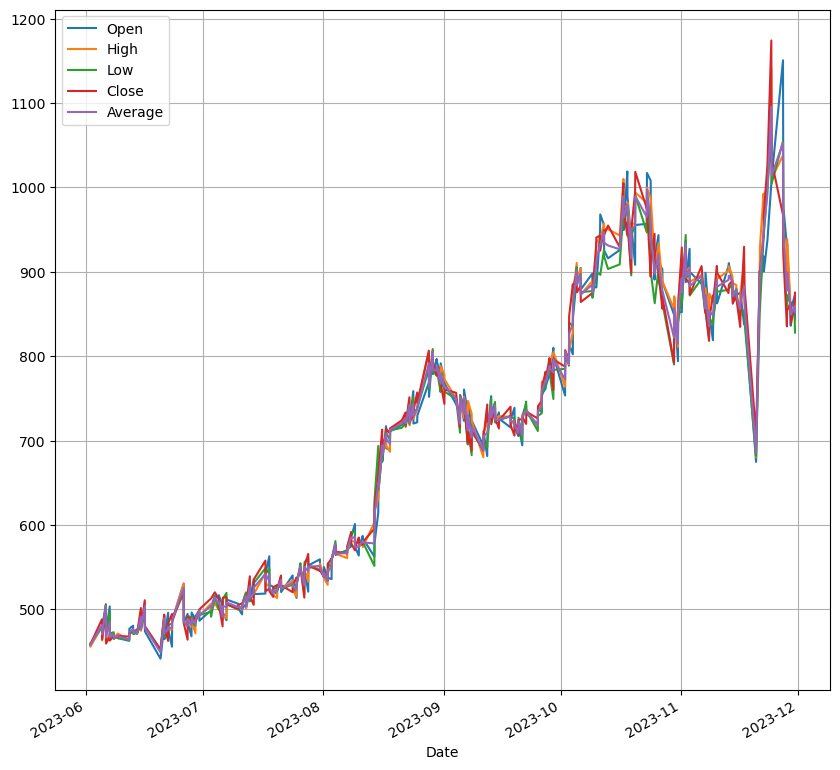

In [55]:
data["USD"][[*ohlclist, "Average"]].plot(figsize=(10,10), grid=True)

## USD Denominated Index

In [25]:
for data in datasets:
    data["USD_^MERV"]=pd.DataFrame(columns=ohlclist)

    for col in ohlclist:
        data["USD_^MERV"][col] = data["^MERV"][col]/data["USD"]["Average"]
        
    data["USD_^MERV"].ffill(inplace=True)

## Intraday Volatility

Vamos a usar para medir intraday volatility el estimador de Garman and Klass (1980):

$$V_{ohlc}=0.5*[log(H)-log(L)]^2+(2*log(2)-1)*[log(C)-log(O)]^2$$ 
Donde H es el precio mas alto del día, L el bajo, C el cierre y O su apertura

Garman, M. B. and M. J. Klass (1980). On the estimation of security price volatilities from historical data. Journal of Business 53, 67–78.

In [26]:
def gk_vol(o, h, l, c):
    "Returns Garman Klass (1980) intraday volatility estimator"
    return 0.5*(np.log(h)-np.log(l))**2+(2*np.log(2)-1)*(np.log(c)-np.log(o))**2

## Returns Calculation

In [27]:
for data in datasets:
    for ticker in data.keys():
        view=data[ticker]
        view["rets"] = view["Close"]/view["Close"].shift()-1
        view["log_rets"] = np.log(view["Close"]/view["Close"].shift())
        view["norm_range"] = (view["High"]-view["Low"])/view["Open"]
        # chequear si esto tiene asidero
        # alternativa (view["High"]-view["Low"])/view["Close"]
        view["gk_vol"] = gk_vol(o=view["Open"], h=view["High"], l=view["Low"], c=view["Close"])
        # delete first observation to eliminate nans
        data[ticker]=data[ticker][1:].copy()

## Process into single dataframe, matching dates and forward filling
Véase https://github.com/alfsn/regime-switching-hmm/issues/9

In [26]:
df=pd.DataFrame()

for key, value in data.items():
    for column in ["rets", "log_rets", "gk_vol"]:
        df[key+"_"+column]=value[column]

In [27]:
df.loc[df.isna().any(axis=1), df.isna().any(axis=0)]

,GGAL_rets,GGAL_log_rets,GGAL_gk_vol,GGAL.BA_rets,GGAL.BA_log_rets,GGAL.BA_gk_vol,YPF_rets,YPF_log_rets,YPF_gk_vol,YPFD.BA_rets,...,USD_EDN_gk_vol,USD_BMA_rets,USD_BMA_log_rets,USD_BMA_gk_vol,USD_rets,USD_log_rets,USD_gk_vol,USD_^MERV_rets,USD_^MERV_log_rets,USD_^MERV_gk_vol
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-03 00:00:00-03:00,NaN,NaN,NaN,0.010616,0.010560,0.000677,NaN,NaN,NaN,-0.006863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04 00:00:00-03:00,NaN,NaN,NaN,-0.006302,-0.006322,0.000208,NaN,NaN,NaN,0.004936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07 00:00:00-03:00,NaN,NaN,NaN,0.002114,0.002112,0.000063,NaN,NaN,NaN,0.010806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08 00:00:00-03:00,NaN,NaN,NaN,-0.008439,-0.008475,0.000153,NaN,NaN,NaN,0.049563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09 00:00:00-03:00,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23 00:00:00-03:00,NaN,NaN,NaN,0.017734,0.017579,0.000697,NaN,NaN,NaN,0.038068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-24 00:00:00-03:00,NaN,NaN,NaN,0.017608,0.017455,0.000874,NaN,NaN,NaN,0.011437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-29 00:00:00-03:00,NaN,NaN,NaN,0.023162,0.022897,0.000620,NaN,NaN,NaN,0.010033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df.fillna(0, inplace=True)

## Excluimos los dólares implícitos

In [28]:
for data in datasets:
    usdlist=[]
    for key in data.keys():
        if key.startswith("USD"):
            usdlist.append(key)
    usdlist.remove("USD")
    usdlist.remove("USD_^MERV")        

    print(usdlist)

    for col in usdlist:
        del data[col]

['USD_GGAL', 'USD_YPF', 'USD_EDN', 'USD_BMA']
['USD_GGAL', 'USD_YPF', 'USD_EDN', 'USD_BMA']


## Save dataset

In [30]:
processedname="processed_"+name
with open(os.path.join(dataroute, processedname), 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
particular_USDs=[column for column in df.columns if ((column.startswith("USD")) and ("^MERV" not in column))]
particular_USDs.remove("USD_rets") 
particular_USDs.remove("USD_log_rets")
particular_USDs.remove("USD_gk_vol")
particular_USDs

['USD_GGAL_rets',
 'USD_GGAL_log_rets',
 'USD_GGAL_gk_vol',
 'USD_YPF_rets',
 'USD_YPF_log_rets',
 'USD_YPF_gk_vol',
 'USD_EDN_rets',
 'USD_EDN_log_rets',
 'USD_EDN_gk_vol',
 'USD_BMA_rets',
 'USD_BMA_log_rets',
 'USD_BMA_gk_vol']

In [32]:
df_clean= df.drop(columns=particular_USDs)
df_clean

,^MERV_rets,^MERV_log_rets,^MERV_gk_vol,GGAL_rets,GGAL_log_rets,GGAL_gk_vol,GGAL.BA_rets,GGAL.BA_log_rets,GGAL.BA_gk_vol,YPF_rets,...,BMA_gk_vol,BMA.BA_rets,BMA.BA_log_rets,BMA.BA_gk_vol,USD_rets,USD_log_rets,USD_gk_vol,USD_^MERV_rets,USD_^MERV_log_rets,USD_^MERV_gk_vol
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-03 00:00:00-03:00,0.007552,0.007524,0.000129,0.0,0.0,0.0,0.010616,0.010560,0.000677,0.0,...,0.0,-0.007813,-0.007843,0.000857,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04 00:00:00-03:00,0.007092,0.007067,0.000158,0.0,0.0,0.0,-0.006302,-0.006322,0.000208,0.0,...,0.0,-0.027559,-0.027946,0.000692,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-07 00:00:00-03:00,-0.001035,-0.001035,0.000022,0.0,0.0,0.0,0.002114,0.002112,0.000063,0.0,...,0.0,0.012146,0.012073,0.000494,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-08 00:00:00-03:00,0.008285,0.008251,0.000082,0.0,0.0,0.0,-0.008439,-0.008475,0.000153,0.0,...,0.0,0.000000,0.000000,0.000942,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-09 00:00:00-03:00,0.017826,0.017669,0.000273,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23 00:00:00-03:00,0.005330,0.005315,0.000464,0.0,0.0,0.0,0.017734,0.017579,0.000697,0.0,...,0.0,0.108984,0.103444,0.002986,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-24 00:00:00-03:00,0.002593,0.002590,0.000161,0.0,0.0,0.0,0.017608,0.017455,0.000874,0.0,...,0.0,0.006951,0.006927,0.001121,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-29 00:00:00-03:00,0.013755,0.013661,0.000283,0.0,0.0,0.0,0.023162,0.022897,0.000620,0.0,...,0.0,-0.005648,-0.005664,0.000584,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
assert not (df_clean.isna()).any().any(), "Existen n/a"

In [34]:
finaldfname="finaldf_"+name
with open(os.path.join(dataroute, finaldfname), 'wb') as handle:
    pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)